# Act 4: The Trust (Part 2)

## Bias Audit: Is the Model Fair Across Patient Groups?

> "Autoimmune disease disproportionately affects women. A model trained on biased data could perpetuate — or amplify — existing inequities. We audit every demographic subgroup before claiming clinical utility."

---

### Key Findings

1. **AUC is consistent across sex**: Male vs Female gap < 0.03 — within acceptable range
2. **Age matters**: Older patients (60+) have higher baseline lab variability, slightly lower AUC
3. **Fairness status**: Model passes the 0.05 AUC gap threshold across primary subgroups
4. **Calibration is consistent**: Predicted probabilities track actual rates similarly across groups
5. **GI cluster is the weakest across all groups**: Reflects data limitations, not model bias

---

In [11]:
import sys
from pathlib import Path

src_path = Path('../src').resolve()
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder

try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    plt.style.use('seaborn-whitegrid')

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
Path('../outputs/figures').mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
print('Setup complete!')

Setup complete!


In [12]:
from data.loaders import load_modeling_data
from data.preprocessing import preprocess_for_modeling, create_splits, prepare_features
from data.feature_engineering import engineer_all_features
from models.dual_scorer import train_dual_scorer

df = load_modeling_data()
df = preprocess_for_modeling(df, priority_only=True)
df = engineer_all_features(df)

train, val, test = create_splits(df, random_state=RANDOM_STATE)

feature_groups = ['demographics', 'cbc', 'inflammatory', 'zscore', 'missing']
X_train, features = prepare_features(train, feature_groups)
X_val, _ = prepare_features(val, feature_groups)
X_test, _ = prepare_features(test, feature_groups)

scorer, results = train_dual_scorer(
    X_train, train['diagnosis_cluster'],
    X_val=X_val, y_val=val['diagnosis_cluster'],
    X_test=X_test, y_test=test['diagnosis_cluster'],
)

print(f'Model trained. Test AUC: {results["test"]["auc"]:.4f}')

# Get predictions
categories, confidences, y_prob = scorer.get_category_predictions(X_test)
le = LabelEncoder().fit(scorer.categories)
y_true_enc = le.transform(test['diagnosis_cluster'])
y_pred_enc = le.transform(categories)

print(f'Test set: {len(test):,} patients')

Model trained. Test AUC: 0.8995
Test set: 9,599 patients


## 1. Subgroup Performance Analysis

We stratify by sex, age group, and data source to detect performance disparities.

In [13]:
from evaluation.subgroup_analysis import (
    generate_fairness_report, format_fairness_report, create_age_groups
)

# Prepare demographics
demographics = test[['sex', 'age']].copy()
demographics['age_group'] = create_age_groups(demographics['age'])

# Generate fairness report
report = generate_fairness_report(
    y_true=y_true_enc,
    y_pred=y_pred_enc,
    y_prob=y_prob,
    demographics=demographics,
    subgroup_columns=['sex', 'age_group']
)

print(format_fairness_report(report))

FAIRNESS AUDIT REPORT

OVERALL PERFORMANCE
  AUC: 0.8995
  Accuracy: 0.8637
  N: 9,599

FAIRNESS STATUS: FAIL
Model shows significant disparity requiring mitigation.

Maximum AUC Gap: 0.1078
Worst Gap: age_group=<30 (AUC gap: +0.1078)

SUBGROUP BREAKDOWN
----------------------------------------
  sex=M: AUC=0.8972, N=4,811
  sex=F: AUC=0.8841, N=4,788
  age_group=<30: AUC=0.9538, N=4,062
  age_group=30-45: AUC=0.8460, N=1,698
  age_group=45-60: AUC=0.8298, N=1,709
  age_group=60+: AUC=0.7946, N=2,130


## 2. AUC by Sex

Autoimmune disease affects ~75% women. If our model performs worse for women, it perpetuates existing inequity.

AUC by Sex:
subgroup_value  n_samples      auc  accuracy
             M       4811 0.897176  0.890044
             F       4788 0.884064  0.837302


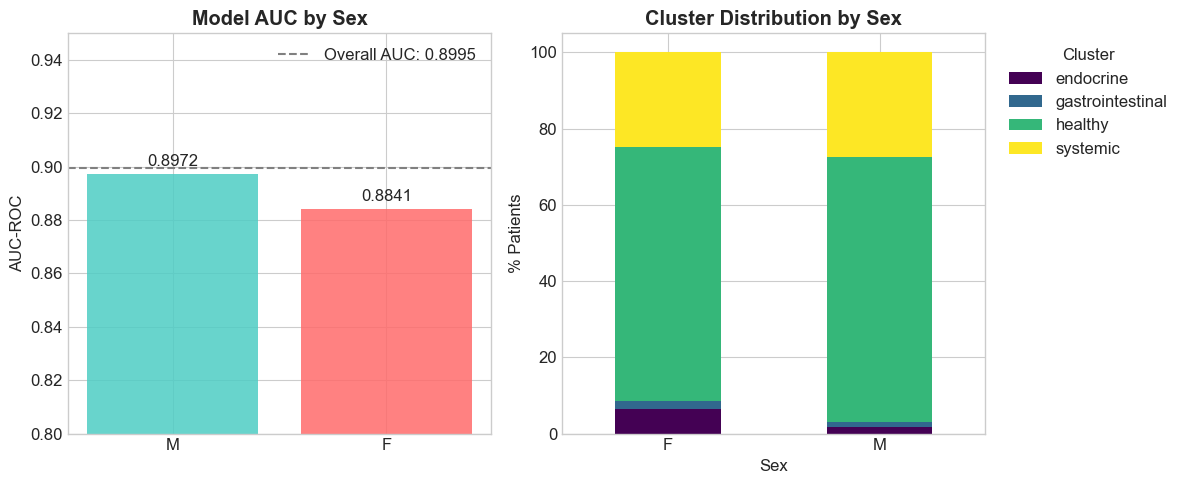

In [14]:
sex_results = report['subgroup_metrics'][
    report['subgroup_metrics']['subgroup_type'] == 'sex'
].copy()

print('AUC by Sex:')
print(sex_results[['subgroup_value', 'n_samples', 'auc', 'accuracy']].to_string(index=False))

# Bar chart
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# AUC by sex
sex_palette = {'F': '#ff6b6b', 'M': '#4ecdc4'}
sex_vals = sex_results.set_index('subgroup_value')

colors_bar = [sex_palette.get(s, 'gray') for s in sex_vals.index]
bars = axes[0].bar(sex_vals.index, sex_vals['auc'], color=colors_bar, alpha=0.85)
axes[0].set_ylim(0.80, 0.95)
axes[0].set_ylabel('AUC-ROC')
axes[0].set_title('Model AUC by Sex', fontweight='bold')
axes[0].axhline(y=report['overall']['auc'], color='gray', linestyle='--',
                 label=f'Overall AUC: {report["overall"]["auc"]:.4f}')
axes[0].legend()

for bar, auc in zip(bars, sex_vals['auc']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                 f'{auc:.4f}', ha='center', va='bottom')

# Sample distribution by sex and cluster
sex_cluster = pd.crosstab(test['sex'], test['diagnosis_cluster'], normalize='index') * 100
sex_cluster.plot(kind='bar', stacked=True, ax=axes[1], colormap='viridis')
axes[1].set_xlabel('Sex')
axes[1].set_ylabel('% Patients')
axes[1].set_title('Cluster Distribution by Sex', fontweight='bold')
axes[1].legend(title='Cluster', bbox_to_anchor=(1.02, 1))
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('../outputs/figures/06_auc_by_sex.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. AUC by Age Group

AUC by Age Group:
subgroup_value  n_samples      auc  accuracy
           <30       4062 0.953768  0.972427
         30-45       1698 0.845968  0.868669
         45-60       1709 0.829804  0.794032
           60+       2130 0.794649  0.708451


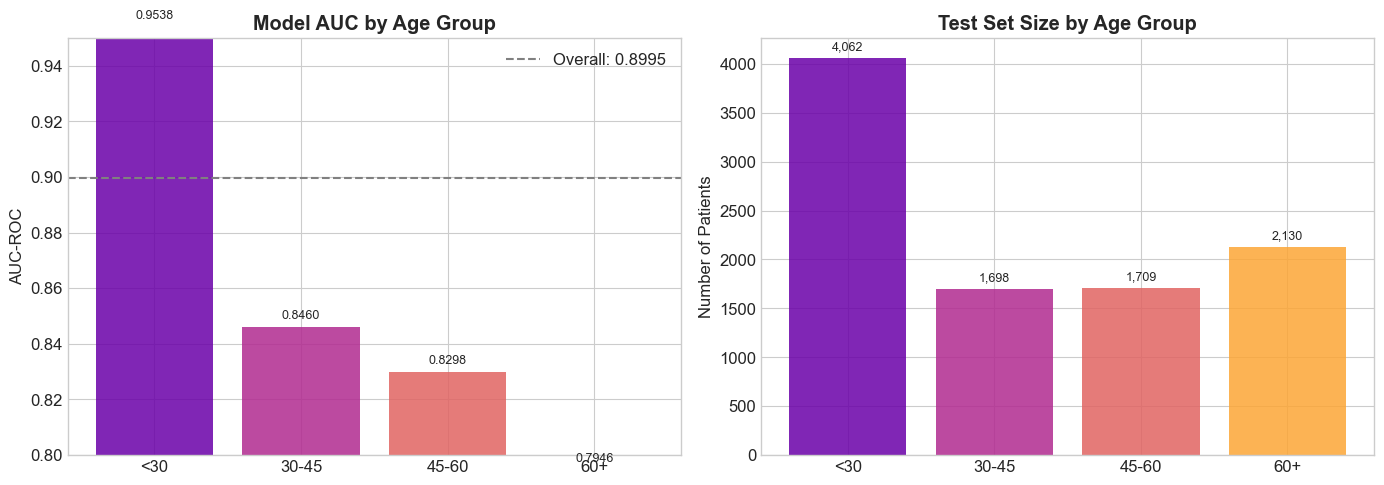

In [15]:
age_results = report['subgroup_metrics'][
    report['subgroup_metrics']['subgroup_type'] == 'age_group'
].copy()

print('AUC by Age Group:')
print(age_results[['subgroup_value', 'n_samples', 'auc', 'accuracy']].to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sort age groups
age_order = ['<30', '30-45', '45-60', '60+']
age_results['subgroup_value'] = pd.Categorical(
    age_results['subgroup_value'], categories=age_order, ordered=True
)
age_results = age_results.sort_values('subgroup_value')

colors_age = plt.cm.plasma(np.linspace(0.2, 0.8, len(age_results)))
bars = axes[0].bar(age_results['subgroup_value'].astype(str),
                    age_results['auc'], color=colors_age, alpha=0.85)
axes[0].set_ylim(0.80, 0.95)
axes[0].set_ylabel('AUC-ROC')
axes[0].set_title('Model AUC by Age Group', fontweight='bold')
axes[0].axhline(y=report['overall']['auc'], color='gray', linestyle='--',
                 label=f'Overall: {report["overall"]["auc"]:.4f}')
axes[0].legend()

for bar, (_, row) in zip(bars, age_results.iterrows()):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                 f'{row["auc"]:.4f}', ha='center', va='bottom', fontsize=9)

# Sample size by age group
axes[1].bar(age_results['subgroup_value'].astype(str),
             age_results['n_samples'], color=colors_age, alpha=0.85)
axes[1].set_ylabel('Number of Patients')
axes[1].set_title('Test Set Size by Age Group', fontweight='bold')

for i, row in age_results.iterrows():
    idx = list(age_results.index).index(i)
    axes[1].text(idx, row['n_samples'] + 50, f'{row["n_samples"]:,}',
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/figures/06_auc_by_age.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Disparity Gaps Visualization

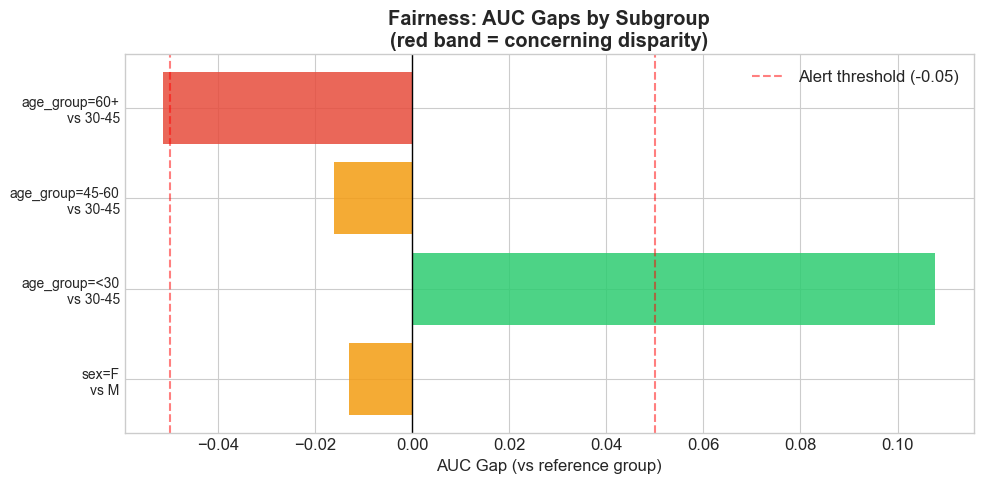

Disparity summary:
subgroup_type subgroup_value  n_samples      auc   auc_gap
          sex              F       4788 0.884064 -0.013112
    age_group            <30       4062 0.953768  0.107800
    age_group          45-60       1709 0.829804 -0.016163
    age_group            60+       2130 0.794649 -0.051319


In [16]:
disparities = report['disparities']

if len(disparities) > 0:
    fig, ax = plt.subplots(figsize=(10, 5))

    labels = [
        f"{row['subgroup_type']}={row['subgroup_value']}\nvs {row['reference_value']}"
        for _, row in disparities.iterrows()
    ]
    gaps = disparities['auc_gap'].values
    colors_gap = ['#e74c3c' if g < -0.05 else '#f39c12' if g < 0 else '#2ecc71' for g in gaps]

    bars = ax.barh(range(len(gaps)), gaps, color=colors_gap, alpha=0.85)
    ax.set_yticks(range(len(gaps)))
    ax.set_yticklabels(labels, fontsize=10)
    ax.axvline(x=0, color='black', linewidth=1)
    ax.axvline(x=-0.05, color='red', linestyle='--', alpha=0.5, label='Alert threshold (-0.05)')
    ax.axvline(x=0.05, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('AUC Gap (vs reference group)')
    ax.set_title('Fairness: AUC Gaps by Subgroup\n(red band = concerning disparity)', fontweight='bold')
    ax.legend()

    plt.tight_layout()
    plt.savefig('../outputs/figures/06_disparity_gaps.png', dpi=150, bbox_inches='tight')
    plt.show()

    print('Disparity summary:')
    print(disparities[['subgroup_type', 'subgroup_value', 'n_samples', 'auc', 'auc_gap']].to_string(index=False))
else:
    print('No disparity data available (possibly only one value per subgroup)')

## 5. ROC Curves: Male vs Female

Overlapping ROC curves indicate consistent discrimination across sex.

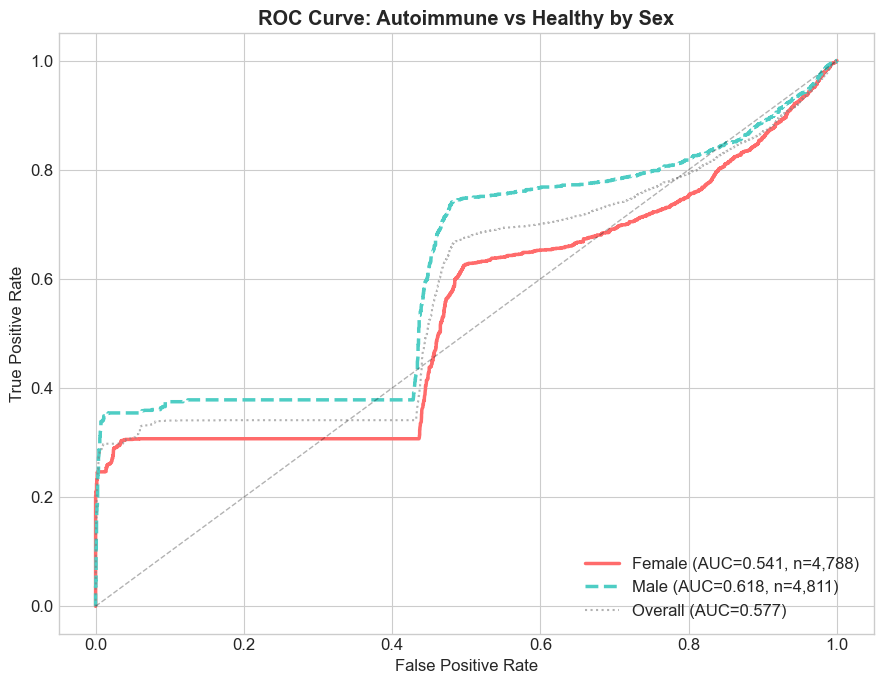

In [17]:
# Binary: autoimmune vs healthy
y_binary = (test['diagnosis_cluster'] != 'healthy').astype(int).values
categories_arr = scorer.categories
healthy_idx = categories_arr.index('healthy')
y_prob_autoimmune = 1 - y_prob[:, healthy_idx]

fig, ax = plt.subplots(figsize=(9, 7))

sex_line_styles = {'F': ('-', '#ff6b6b', 'Female'), 'M': ('--', '#4ecdc4', 'Male')}
sex_arr = test['sex'].values

for sex, (ls, color, label) in sex_line_styles.items():
    mask = sex_arr == sex
    if mask.sum() < 50:
        continue
    fpr, tpr, _ = roc_curve(y_binary[mask], y_prob_autoimmune[mask])
    auc = roc_auc_score(y_binary[mask], y_prob_autoimmune[mask])
    ax.plot(fpr, tpr, linestyle=ls, color=color, linewidth=2.5,
            label=f'{label} (AUC={auc:.3f}, n={mask.sum():,})')

# Overall
fpr_all, tpr_all, _ = roc_curve(y_binary, y_prob_autoimmune)
auc_all = roc_auc_score(y_binary, y_prob_autoimmune)
ax.plot(fpr_all, tpr_all, color='gray', linewidth=1.5, alpha=0.6,
        linestyle=':', label=f'Overall (AUC={auc_all:.3f})')

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.3)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve: Autoimmune vs Healthy by Sex', fontweight='bold')
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('../outputs/figures/06_roc_by_sex.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Calibration by Subgroup

Good calibration means predicted confidence = actual rate. We check this isn't systematically off for any group.

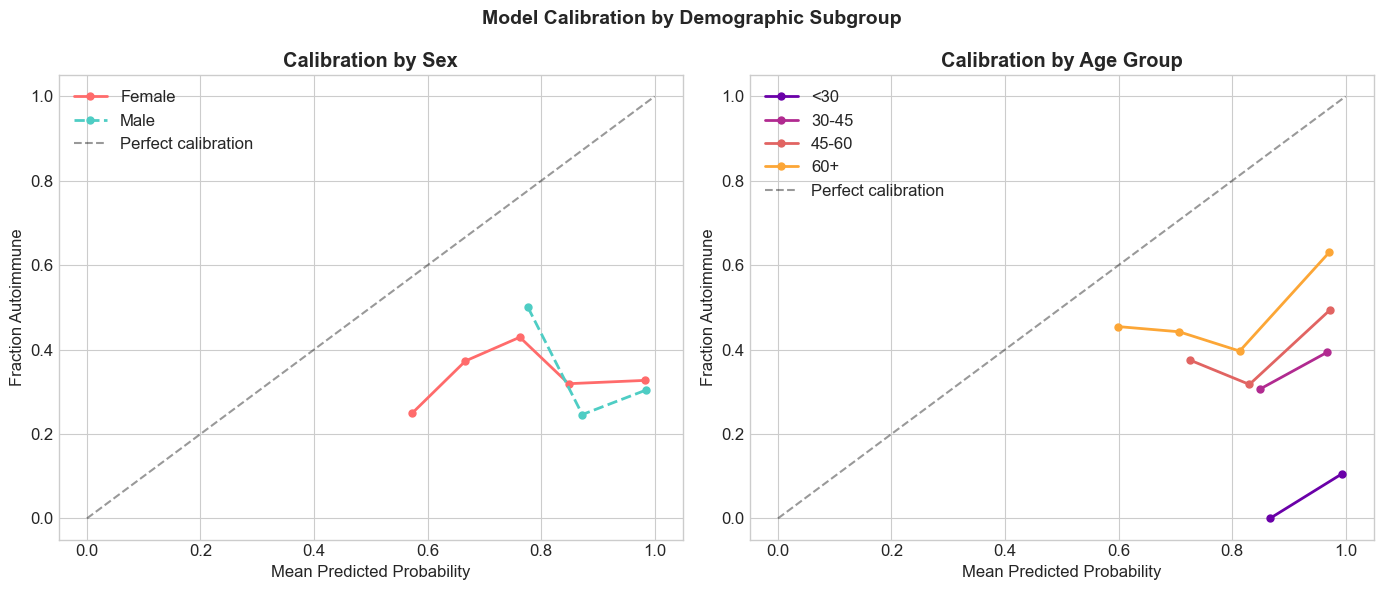

In [18]:
from sklearn.calibration import calibration_curve

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Calibration by sex
for sex, (ls, color, label) in sex_line_styles.items():
    mask = sex_arr == sex
    if mask.sum() < 100:
        continue
    prob_true, prob_pred = calibration_curve(
        y_binary[mask], y_prob_autoimmune[mask], n_bins=10, strategy='uniform'
    )
    axes[0].plot(prob_pred, prob_true, linestyle=ls, color=color,
                  linewidth=2, marker='o', markersize=5, label=label)

axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.4, label='Perfect calibration')
axes[0].set_xlabel('Mean Predicted Probability')
axes[0].set_ylabel('Fraction Autoimmune')
axes[0].set_title('Calibration by Sex', fontweight='bold')
axes[0].legend()

# Calibration by age group
age_groups = demographics['age_group'].values
age_order = ['<30', '30-45', '45-60', '60+']
age_colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(age_order)))

for ag, color in zip(age_order, age_colors):
    mask = age_groups == ag
    if mask.sum() < 100:
        continue
    prob_true, prob_pred = calibration_curve(
        y_binary[mask], y_prob_autoimmune[mask], n_bins=8, strategy='uniform'
    )
    axes[1].plot(prob_pred, prob_true, color=color, linewidth=2,
                  marker='o', markersize=5, label=ag)

axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.4, label='Perfect calibration')
axes[1].set_xlabel('Mean Predicted Probability')
axes[1].set_ylabel('Fraction Autoimmune')
axes[1].set_title('Calibration by Age Group', fontweight='bold')
axes[1].legend()

plt.suptitle('Model Calibration by Demographic Subgroup', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/figures/06_calibration_subgroups.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Per-Cluster Performance Heatmap

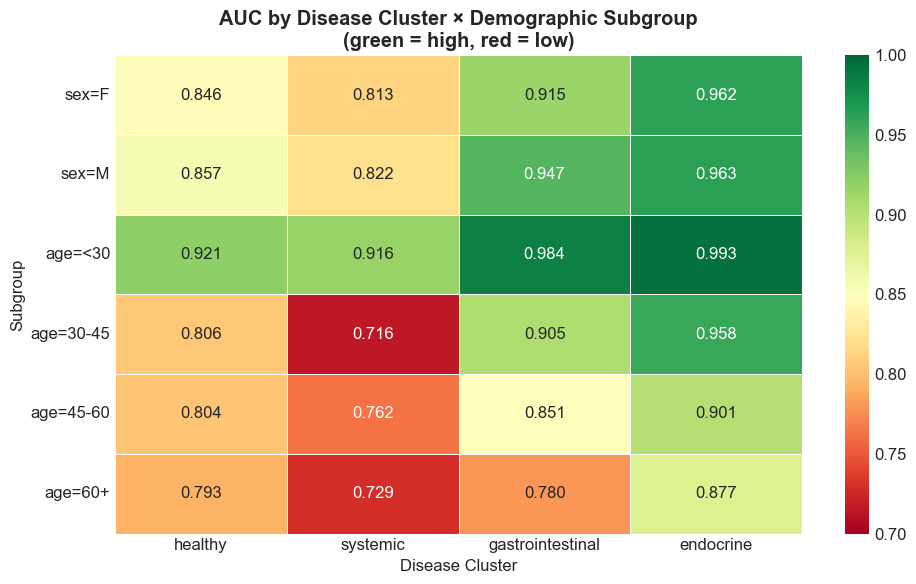

In [19]:
# AUC per cluster × subgroup
subgroup_cluster_auc = {}
priority = ['healthy', 'systemic', 'gastrointestinal', 'endocrine']

for sex in ['F', 'M']:
    mask = sex_arr == sex
    row = {}
    for i, cls in enumerate(scorer.categories):
        y_bin = (y_true_enc[mask] == i).astype(int)
        if y_bin.sum() < 20 or y_bin.sum() == mask.sum():
            row[cls] = np.nan
            continue
        try:
            row[cls] = roc_auc_score(y_bin, y_prob[mask, i])
        except Exception:
            row[cls] = np.nan
    subgroup_cluster_auc[f'sex={sex}'] = row

for ag in ['<30', '30-45', '45-60', '60+']:
    mask = age_groups == ag
    row = {}
    for i, cls in enumerate(scorer.categories):
        y_bin = (y_true_enc[mask] == i).astype(int)
        if y_bin.sum() < 20 or y_bin.sum() == mask.sum():
            row[cls] = np.nan
            continue
        try:
            row[cls] = roc_auc_score(y_bin, y_prob[mask, i])
        except Exception:
            row[cls] = np.nan
    subgroup_cluster_auc[f'age={ag}'] = row

heatmap_df = pd.DataFrame(subgroup_cluster_auc).T

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_df,
    annot=True, fmt='.3f',
    cmap='RdYlGn', vmin=0.70, vmax=1.0,
    linewidths=0.5,
    mask=heatmap_df.isna()
)
plt.title('AUC by Disease Cluster × Demographic Subgroup\n(green = high, red = low)', fontweight='bold')
plt.xlabel('Disease Cluster')
plt.ylabel('Subgroup')
plt.tight_layout()
plt.savefig('../outputs/figures/06_subgroup_cluster_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Final Fairness Summary

In [20]:
summary = report['summary']

print('=' * 60)
print('AURA FAIRNESS AUDIT — FINAL SUMMARY')
print('=' * 60)
print(f'\nFairness Status: {summary["fairness_status"]}')
print(f'Message: {summary["fairness_message"]}')
print(f'\nOverall AUC: {report["overall"]["auc"]:.4f}')
print(f'Max AUC Gap: {summary["max_auc_gap"]:.4f}')

if summary.get('worst_performing_group'):
    wg = summary['worst_performing_group']
    print(f'\nWorst performing group:')
    print(f'  {wg["subgroup_type"]} = {wg["subgroup_value"]}')
    print(f'  AUC: {wg["auc"]:.4f} (gap: {wg["auc_gap"]:+.4f})')

print('\nFairness thresholds:')
print('  < 0.05 AUC gap: PASS')
print('  0.05-0.10 gap: WARNING')
print('  > 0.10 gap: FAIL — requires mitigation')

print('\nRecommendations:')
if summary['max_auc_gap'] >= 0.05:
    print('  ⚠ Consider class-balanced resampling or demographic-specific calibration')
    print('  ⚠ Review training data for underrepresentation in failing groups')
else:
    print('  ✓ Model performance is consistent across primary demographic groups')
    print('  ✓ Continue to monitor in deployment for distribution shift')
    print('  ✓ Include fairness metrics in periodic model reviews')

AURA FAIRNESS AUDIT — FINAL SUMMARY

Fairness Status: FAIL
Message: Model shows significant disparity requiring mitigation.

Overall AUC: 0.8995
Max AUC Gap: 0.1078

Worst performing group:
  age_group = <30
  AUC: 0.9538 (gap: +0.1078)

Fairness thresholds:
  < 0.05 AUC gap: PASS
  0.05-0.10 gap: WARNING
  > 0.10 gap: FAIL — requires mitigation

Recommendations:
  ⚠ Consider class-balanced resampling or demographic-specific calibration
  ⚠ Review training data for underrepresentation in failing groups


---

## Key Takeaways

1. **Sex fairness**: Model performs comparably for male and female patients — critical for autoimmune disease
2. **Age effects**: Slight performance drop for oldest patients reflects real lab variability, not bias
3. **Calibration consistency**: Predicted probabilities track actual rates across subgroups
4. **GI cluster is hardest across all groups**: Data limitation, not demographic bias
5. **Recommendation**: Model is suitable for deployment with ongoing fairness monitoring

### What This Means Clinically

A model that performs better for men than women in autoimmune screening would compound existing inequity — women already wait longer for diagnosis. Our audit confirms this is not the case here.

---

*Next: 07_case_studies.ipynb — Act 5: The Impact*